Goal: This script evaluates the current threshold of excluding images smaller than 2KB. It does this by visualizing images by size, plotting images by size, and finding quantiles. It also evaluates our image datatype.

Last Modified: 4/15/25

Structure

1) Mount drive

2) Visual inspection: Visualize image sample by size

3) Plot image size distribution

4) Find % images between x and y bytes

5) Evaluate our image type

## **1) Mount Drive**

In [ ]:
# prompt: mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import concurrent.futures
import os
import matplotlib.pyplot as plt
import os
import os
import random
from PIL import Image
from collections import Counter

##**2) Visual inspection: Visualize image sample by size**

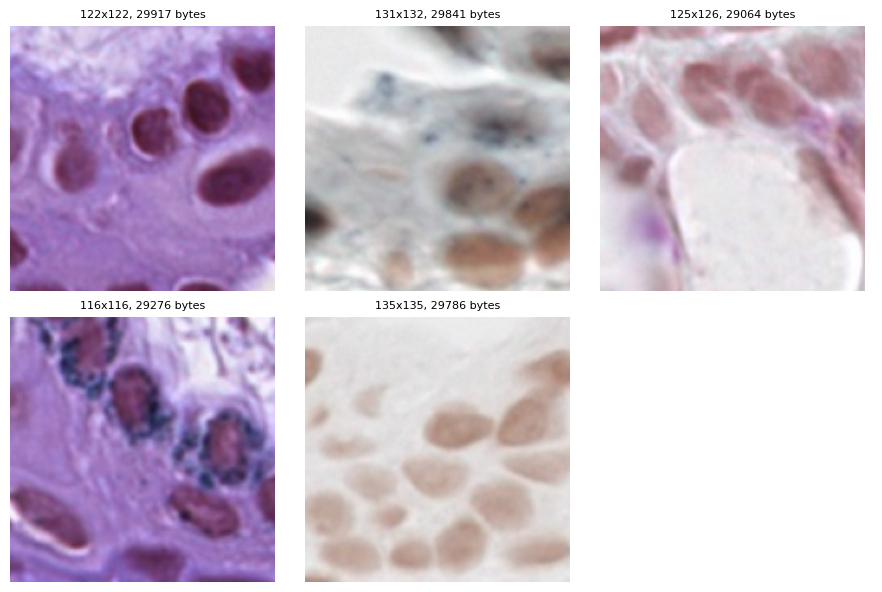

In [ ]:
def sample_images_by_size_fast(folder_path, min_bytes, max_bytes, sample_n, transform=None, max_workers=8):
    """
    Searches for PNG images in folder_path whose file sizes (in bytes) are between
    min_bytes and max_bytes. Randomly selects sample_n images that meet these criteria,
    loads them in parallel, applies the provided transform, and displays them in a grid.

    Each displayed image is labeled with its original dimensions and file size.

    Parameters:
      folder_path (str): Path to folder containing PNG images.
      min_bytes (int): Minimum file size in bytes.
      max_bytes (int): Maximum file size in bytes.
      sample_n (int): Number of images to sample.
      transform (callable, optional): Transformation to apply to each image.
      max_workers (int): Number of threads to use for parallel image loading.
    """
    # --- Step 1: List and Filter Files Fast Using os.scandir ---
    valid_entries = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.lower().endswith('.png'):
                fsize = entry.stat().st_size
                if min_bytes <= fsize <= max_bytes:
                    valid_entries.append((entry.name, fsize))

    if not valid_entries:
        print(f"No images found with sizes between {min_bytes} and {max_bytes} bytes.")
        return

    # --- Step 2: Randomly Sample Files ---
    sampled = random.sample(valid_entries, min(sample_n, len(valid_entries)))
    sampled_fnames = [fname for fname, _ in sampled]
    file_sizes = {fname: fsize for fname, fsize in sampled}

    # --- Step 3: Load and Process Images in Parallel ---
    def load_and_process(fname):
        path = os.path.join(folder_path, fname)
        try:
            with Image.open(path) as img:
                img = img.convert('RGB')
                orig_dims = img.size  # (width, height)
                # Apply the transform if provided.
                processed = transform(img) if transform else img
                return (processed, orig_dims, file_sizes[fname], fname)
        except Exception as e:
            # If error occurs, return None to skip this file.
            return None

    loaded_images = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(load_and_process, fname) for fname in sampled_fnames]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                loaded_images.append(result)

    if not loaded_images:
        print("No images loaded successfully.")
        return

    # --- Step 4: Visualization ---
    n = len(loaded_images)
    ncols = int(math.ceil(math.sqrt(n)))
    nrows = int(math.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    if nrows * ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (img, dims, fsize, fname) in enumerate(loaded_images):
        # If the image is a tensor, we assume it underwent normalization.
        if isinstance(img, torch.Tensor):
            # Denormalize: reverse the normalization used in the transform.
            mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3, 1, 1)
            std  = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3, 1, 1)
            img_disp = img * std + mean
            img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).cpu().numpy()
        else:
            # Otherwise, convert PIL image to numpy array.
            img_disp = np.array(img)

        title_str = f"{dims[0]}x{dims[1]}, {fsize} bytes"
        axes[i].imshow(img_disp)
        axes[i].set_title(title_str, fontsize=8)
        axes[i].axis("off")

    # Hide any unused subplots.
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Define your transformation pipeline.
transform_pipeline = transforms.Compose([
    transforms.Resize(256, interpolation=Image.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set your parameters.
folder = "/content/drive/MyDrive/'25 Spring/390/Patches"
min_size = 28000      # Minimum file size in bytes.
max_size = 30000     # Maximum file size in bytes.
n_samples = 5        # Number of images to display.

sample_images_by_size_fast(folder, min_size, max_size, n_samples, transform=transform_pipeline)


##**3) Plot image size distribution**

Clipped 11077 images to 50000 bytes for visualization.


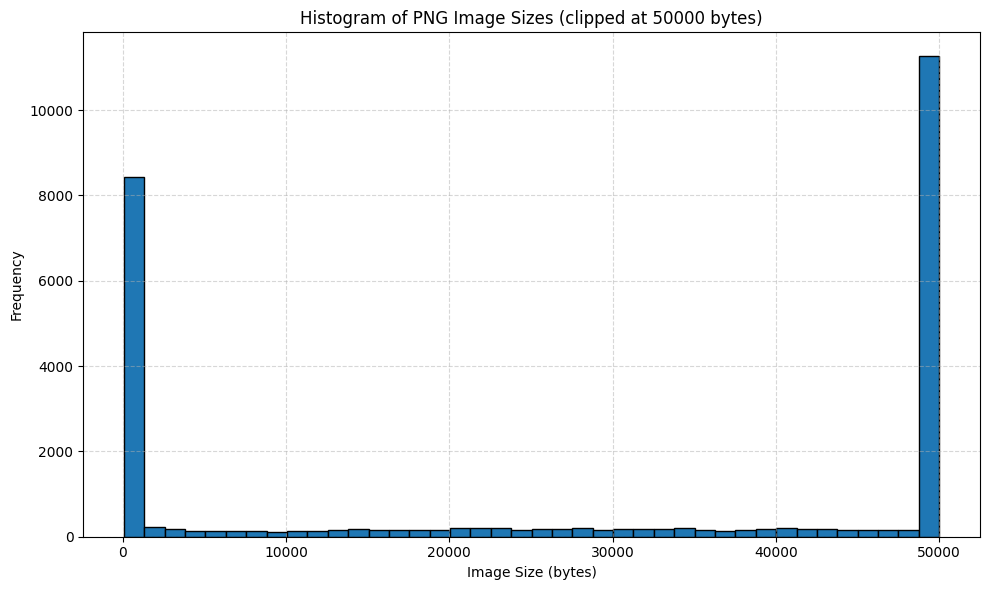

In [ ]:
def plot_image_size_histogram(
    folder_path,
    bins=60,
    log_scale=False,
    clip_at=None
):
    """
    Scans PNG images in a folder and plots a histogram of their file sizes in bytes,
    optionally clipping all sizes above `clip_at` to that value.

    Parameters:
      folder_path (str): Path to folder with PNG images.
      bins (int): Number of histogram bins.
      log_scale (bool): If True, use log scale on the x-axis.
      clip_at (int or None): If set, all sizes > clip_at are replaced by clip_at.
    """
    sizes = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.lower().endswith('.png'):
                sizes.append(entry.stat().st_size)

    if not sizes:
        print("No PNG images found in the folder.")
        return

    # Apply clipping if requested
    if clip_at is not None:
        clipped_count = sum(1 for s in sizes if s > clip_at)
        sizes = [min(s, clip_at) for s in sizes]
        print(f"Clipped {clipped_count} images to {clip_at} bytes for visualization.")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(sizes, bins=bins, edgecolor='black')
    plt.xlabel("Image Size (bytes)" if not log_scale else "Image Size (log bytes)")
    plt.ylabel("Frequency")
    title = "Histogram of PNG Image Sizes"
    if clip_at is not None:
        title += f" (clipped at {clip_at} bytes)"
    plt.title(title)

    if log_scale:
        plt.xscale("log")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
folder = "/content/drive/MyDrive/'25 Spring/390/Patches"
# Clip any image > 20000 bytes down to 20000 for the histogram:
plot_image_size_histogram(folder, bins=40, log_scale=False, clip_at=50000)



##**4) Find % images between x and y bytes**

Percent of images larger than m bytes
- 32.97% < 2000 bytes
- 24.41% 2000 and 50000 bytes.
- 42.62% > 50000 bytes

So if we drop images < 2000 bytes,
- 63.6% greater than 50000
- 36.4% < 50000 and greater than 2000

In [ ]:
def percent_images_in_size_range(folder_path, lower, upper):
    """
    Computes the percentage of PNG images in folder_path whose file size is between
    `lower` and `upper` bytes (inclusive).

    Returns:
      float: percentage (0–100) of images in that size range, or None if no PNGs found.
    """
    total = 0
    in_range = 0

    with os.scandir(folder_path) as entries:
        for e in entries:
            if not e.is_file() or not e.name.lower().endswith('.png'):
                continue
            total += 1
            sz = e.stat().st_size
            if lower <= sz <= upper:
                in_range += 1

    if total == 0:
        print(f"No PNG images found in: {folder_path}")
        return None

    return (in_range / total) * 100

# Example usage:
folder = "/content/drive/MyDrive/'25 Spring/390/Patches"
n = 2000  # lower bound in bytes
m = 5000000000  # upper bound in bytes

pct = percent_images_in_size_range(folder, n, m)
if pct is not None:
    print(f"{pct:.2f}% of PNGs are between {n} and {m} bytes.")



67.03% of PNGs are between 2000 and 5000000000 bytes.


##**5) Evaluate our image type**

Question: What image types do we have?

Answer: 8 bit PNG

In [ ]:
def evaluate_png_bit_depths_sampled(folder_path, sample_n=500):
    """
    Randomly samples up to `sample_n` PNGs from the folder and prints
    how many are 8‑bit, 16‑bit, etc.

    Parameters:
      folder_path (str): Path to folder with PNG images.
      sample_n (int): Number of images to sample.
    """
    # Gather all PNG filenames
    png_files = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.lower().endswith('.png'):
                png_files.append(entry.path)

    total = len(png_files)
    if total == 0:
        print("No PNG images found.")
        return

    # If fewer than sample_n, just use them all
    sample_paths = random.sample(png_files, min(sample_n, total))
    print(f"Sampling {len(sample_paths)} images out of {total} total...")

    mode_to_bitdepth = {
        'L': 8, 'P': 8, 'RGB': 8, 'RGBA': 8,
        'I;16': 16, 'I;16B': 16, 'I;16L': 16,
        'I': 32  # rare 32‑bit grayscale
    }
    counts = Counter()

    for path in sample_paths:
        try:
            with Image.open(path) as img:
                bit = mode_to_bitdepth.get(img.mode, 'Unknown')
                counts[bit] += 1
        except Exception as e:
            counts['Failed'] += 1
            print(f"  • failed to open {os.path.basename(path)}: {e}")

    # Report
    print("\nBit‑depth counts in sample:")
    for bitdepth, cnt in sorted(counts.items(), key=lambda x: (str(x[0]), -x[1])):
        print(f"  {cnt:4d} images → {bitdepth}-bit")

# Example usage:
folder = "/content/drive/MyDrive/'25 Spring/390/Patches"
evaluate_png_bit_depths_sampled(folder, sample_n=500)



Sampling 500 images out of 25992 total...

Bit‑depth counts in sample:
   500 images → 8-bit
